In [3]:
from dy_filtering import read_training_dynamics, compute_train_dy_metrics

## 1. 使用 `read_training_dynamics` 函数，指定放置所有 epoch 的 training_dynamics 的目录，将他们都读取到一个 dictionary 中：

In [4]:
td = read_training_dynamics('dy_log/sst2/bert-tiny/')
len(td), type(td)

2022-07-07 13:06:46,588 - INFO - selection_utils - Reading 10 files from dy_log/sst2/bert-tiny/training_dynamics ...
100%|██████████| 10/10 [00:07<00:00,  1.40it/s]
2022-07-07 13:06:53,756 - INFO - selection_utils - Read training dynamics for 67349 train instances.


(67349, dict)

## 2. 使用 `compute_train_dy_metrics` 函数来计算出每个 sample 的各种 metrics：
包括：
- confidence
- variability
- correctness
- forgetfulness

In [5]:
td_df, _ = compute_train_dy_metrics(td, burn_out=4)
td_df.head()

2022-07-07 13:06:55,616 - INFO - dy_filtering - Computing training dynamics. Burning out at 4 of 10. 
2022-07-07 13:06:55,618 - INFO - dy_filtering - Metrics computed: confidence, variability, correctness, forgetfulness, threshold_closeness
100%|██████████| 67349/67349 [00:29<00:00, 2310.22it/s]


,guid,index,threshold_closeness,confidence,variability,correctness,forgetfulness
0,6480,0,0.241855,0.409752,0.147358,1,1
1,31866,1,0.146504,0.821708,0.059223,4,0
2,478,2,0.126697,0.851145,0.089703,4,0
3,13711,3,0.113017,0.870112,0.083015,4,0
4,37840,4,0.150168,0.815962,0.131296,4,0


## 3. 绘制 Data Map：

Plotting figure for sst2 using the bert-tiny model ...


[]

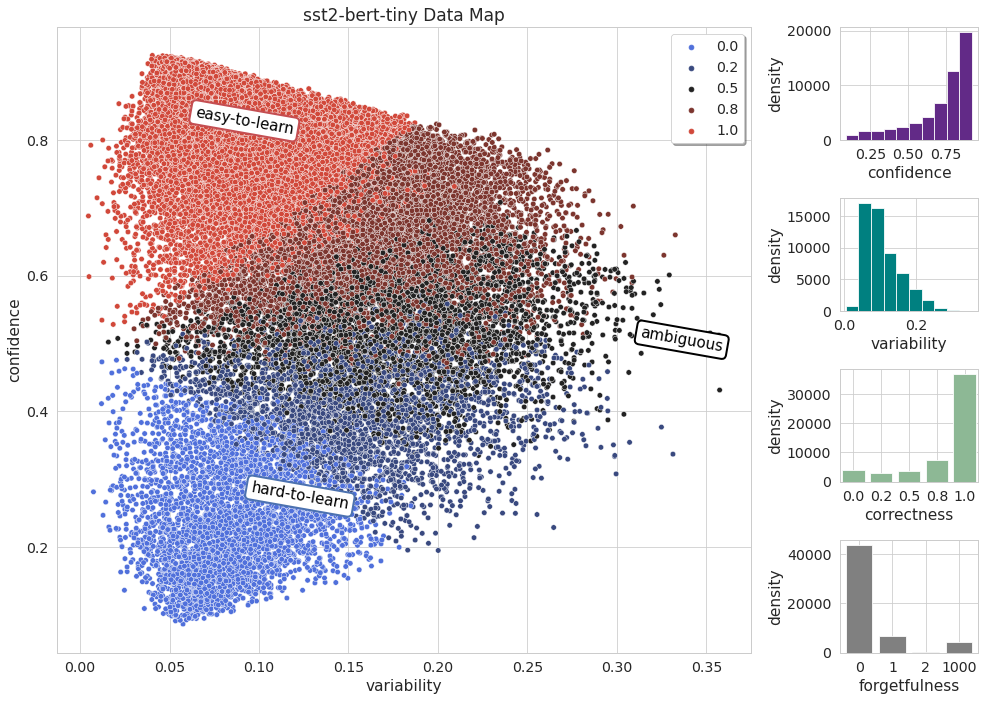

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# --------------------------------
dataframe = td_df
plot_dir = ''
hue_metric = 'correct.'
title = 'sst2'
model = 'bert-tiny'
show_hist = True
max_instances_to_plot = 55000 #55000
# --------------------------------

# Set style.
sns.set(style='whitegrid', font_scale=1.6, context='paper') # font='Georgia'
print(f"Plotting figure for {title} using the {model} model ...")

# Subsample data to plot, so the plot is not too busy.
dataframe = dataframe.sample(n=max_instances_to_plot if dataframe.shape[0] > max_instances_to_plot else len(dataframe))

# Normalize correctness to a value between 0 and 1.
dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
dataframe['correct.'] = [float(f"{x:.1f}") for x in dataframe['corr_frac']]

main_metric = 'variability'
other_metric = 'confidence'

hue = hue_metric
num_hues = len(dataframe[hue].unique().tolist())
style = hue_metric if num_hues < 8 else None

if not show_hist:
    fig, ax0 = plt.subplots(1, 1, figsize=(8, 6))
else:
    fig = plt.figure(figsize=(14, 10), )
    gs = fig.add_gridspec(4, 2, width_ratios=[5, 1])  # 构造一个三行两列的图，两列的宽度比例是 5:1
    ax0 = fig.add_subplot(gs[:, 0]) # ax0是一个子图，位置在整个fig的第一列区域

# Make the scatterplot.
# Choose a palette.
pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

plot = sns.scatterplot(x=main_metric, y=other_metric,
                       ax=ax0, data=dataframe, hue=hue,
                       palette=pal, s=30) # style=style 添加style的话，就会使用不用的 marker，但是就没法保证 legend 按照值的大小排列了

# Annotate Regions.
bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
func_annotate = lambda text, xyc, bbc : ax0.annotate(text, xy=xyc, xycoords="axes fraction", fontsize=15, 
                                                     color='black', va="center", ha="center", 
                                                     rotation=350, bbox=bb(bbc))
an1 = func_annotate("ambiguous", xyc=(0.9, 0.5), bbc='black')
an2 = func_annotate("easy-to-learn", xyc=(0.27, 0.85), bbc='r')
an3 = func_annotate("hard-to-learn", xyc=(0.35, 0.25), bbc='b')


if not show_hist:
    plot.legend(ncol=1, bbox_to_anchor=[0.175, 0.5], loc='right')
else:
    plot.legend(fancybox=True, shadow=True, ncol=1)

plot.set_xlabel('variability')
plot.set_ylabel('confidence')

if show_hist:
    plot.set_title(f"{title}-{model} Data Map", fontsize=17)

    # Make the histograms.
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 1])
    ax3 = fig.add_subplot(gs[2, 1])
    ax4 = fig.add_subplot(gs[3, 1])

    plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
    plott0[0].set_title('')
    plott0[0].set_xlabel('confidence')
    plott0[0].set_ylabel('density')

    plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
    plott1[0].set_title('')
    plott1[0].set_xlabel('variability')
    plott1[0].set_ylabel('density')

    plot2 = sns.countplot(x="correct.", data=dataframe, ax=ax3, color='#86bf91')
    ax3.xaxis.grid(True) # Show the vertical gridlines
    plot2.set_title('')
    plot2.set_xlabel('correctness')
    plot2.set_ylabel('density')

    plot3 = sns.countplot(x="forgetfulness", data=dataframe, ax=ax4, color='gray')
    ax4.xaxis.grid(True) # Show the vertical gridlines
    plot3.set_title('')
    plot3.set_xlabel('forgetfulness')
    plot3.set_ylabel('density')
fig.tight_layout()

plt.plot()
# # save
# filename = f'{plot_dir}/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
# fig.savefig(filename, dpi=300)
# print(f"Plot saved to {filename}")

# 对比不同模型的 training dynamics

In [7]:
td_weak = read_training_dynamics('dy_log/sst2/bert-tiny/')
td_strong = read_training_dynamics('dy_log/sst2/roberta-large/')

td_df_weak, _ = compute_train_dy_metrics(td_weak, burn_out=4)
td_df_strong, _ = compute_train_dy_metrics(td_strong, burn_out=4)

2022-07-07 13:08:46,916 - INFO - selection_utils - Reading 10 files from dy_log/sst2/bert-tiny/training_dynamics ...
100%|██████████| 10/10 [00:04<00:00,  2.18it/s]
2022-07-07 13:08:51,508 - INFO - selection_utils - Read training dynamics for 67349 train instances.
2022-07-07 13:08:51,693 - INFO - selection_utils - Reading 4 files from dy_log/sst2/roberta-large/training_dynamics ...
100%|██████████| 4/4 [00:02<00:00,  1.71it/s]
2022-07-07 13:08:54,035 - INFO - selection_utils - Read training dynamics for 67349 train instances.
2022-07-07 13:08:54,037 - INFO - dy_filtering - Computing training dynamics. Burning out at 4 of 10. 
2022-07-07 13:08:54,038 - INFO - dy_filtering - Metrics computed: confidence, variability, correctness, forgetfulness, threshold_closeness
100%|██████████| 67349/67349 [00:30<00:00, 2184.98it/s]
2022-07-07 13:09:25,225 - INFO - dy_filtering - Computing training dynamics across 4 epochs
2022-07-07 13:09:25,226 - INFO - dy_filtering - Metrics computed: confidence, 

In [10]:
from tqdm import tqdm
weak_dict = {}
for row in tqdm(td_df_weak.iterrows()):
    weak_dict[int(row[1]['guid'])] = {}
    weak_dict[int(row[1]['guid'])]['confidence'] = row[1]['confidence']
    weak_dict[int(row[1]['guid'])]['variability'] = row[1]['variability']
    weak_dict[int(row[1]['guid'])]['correctness'] = row[1]['correctness']
    weak_dict[int(row[1]['guid'])]['forgetfulness'] = row[1]['forgetfulness']

strong_dict = {}
for row in tqdm(td_df_strong.iterrows()):
    strong_dict[int(row[1]['guid'])] = {}
    strong_dict[int(row[1]['guid'])]['confidence'] = row[1]['confidence']
    strong_dict[int(row[1]['guid'])]['variability'] = row[1]['variability']
    strong_dict[int(row[1]['guid'])]['correctness'] = row[1]['correctness']
    strong_dict[int(row[1]['guid'])]['forgetfulness'] = row[1]['forgetfulness']

len(strong_dict) == len(weak_dict)

67349it [00:09, 7150.94it/s]
67349it [00:09, 7023.21it/s]


True

In [11]:
# metric 的变化
delta_dict = {}
all_ids, con_list, var_list, cor_list, for_list = [],[],[],[],[]

# confidence 视角下，weak 和 strong 两个维度
weak_con_list, strong_con_list = [],[]
# variability 视角下，weak 和 strong 两个维度
weak_var_list, strong_var_list = [],[]

"""
`delta_dict` looks like:
{50325: {'confidence': 0.3334124907851219,
         'variability': 0.2199623806463448,
         'correctness': 1.0,
         'forgetfulness': 1.0},
  ...
"""
for guid in tqdm(strong_dict):
    delta_dict[guid] = {}
    delta_dict[guid]['confidence'] = strong_dict[guid]['confidence'] - weak_dict[guid]['confidence']  # 一般都为 提升
    delta_dict[guid]['variability'] = -1*(weak_dict[guid]['variability'] - strong_dict[guid]['variability']) # 一般为 下降，所以使用 weak - strong
    delta_dict[guid]['correctness'] = strong_dict[guid]['correctness'] - weak_dict[guid]['correctness'] # 一般都为 提升
    delta_dict[guid]['forgetfulness'] = -1*(weak_dict[guid]['forgetfulness'] - strong_dict[guid]['forgetfulness']) # 一般为 下降，所以使用 weak - strong
    all_ids.append(guid)
    con_list.append(delta_dict[guid]['confidence'])
    var_list.append(delta_dict[guid]['variability'])
    cor_list.append(delta_dict[guid]['correctness'])
    for_list.append(delta_dict[guid]['forgetfulness'])
    weak_con_list.append(weak_dict[guid]['confidence'])
    strong_con_list.append(strong_dict[guid]['confidence'])
    weak_var_list.append(weak_dict[guid]['variability'])
    strong_var_list.append(strong_dict[guid]['variability'])
len(delta_dict)

delta_td_df = pd.DataFrame({'guid':all_ids,'confidence':con_list,'variability':var_list,'correctness':cor_list,'forgetfulness':for_list})
print(delta_td_df.head())

con_compare_df = pd.DataFrame({'guid':all_ids, 'strong_model':strong_con_list, 'weak_model':weak_con_list})
print(con_compare_df.head())
var_compare_df = pd.DataFrame({'guid':all_ids, 'strong_model':strong_var_list, 'weak_model':weak_var_list})
print(var_compare_df.head())

100%|██████████| 67349/67349 [00:00<00:00, 181476.06it/s]


    guid  confidence  variability  correctness  forgetfulness
0  50325    0.333412    -0.219962          1.0           -1.0
1  42123    0.104232    -0.073384          0.0           -0.0
2  42936    0.059431    -0.075412          0.0           -0.0
3  13963    0.106418    -0.085247          0.0           -0.0
4  47981    0.284476    -0.218293          1.0           -0.0
    guid  strong_model  weak_model
0  50325      0.996026    0.662614
1  42123      0.998754    0.894522
2  42936      0.958638    0.899206
3  13963      0.998325    0.891907
4  47981      0.996244    0.711768
    guid  strong_model  weak_model
0  50325      0.001285    0.221247
1  42123      0.000771    0.074155
2  42936      0.009524    0.084936
3  13963      0.001487    0.086734
4  47981      0.000789    0.219082


Plotting figure for SST2 using the RoBERTa-large vs. BERT-tiny model ...


[]

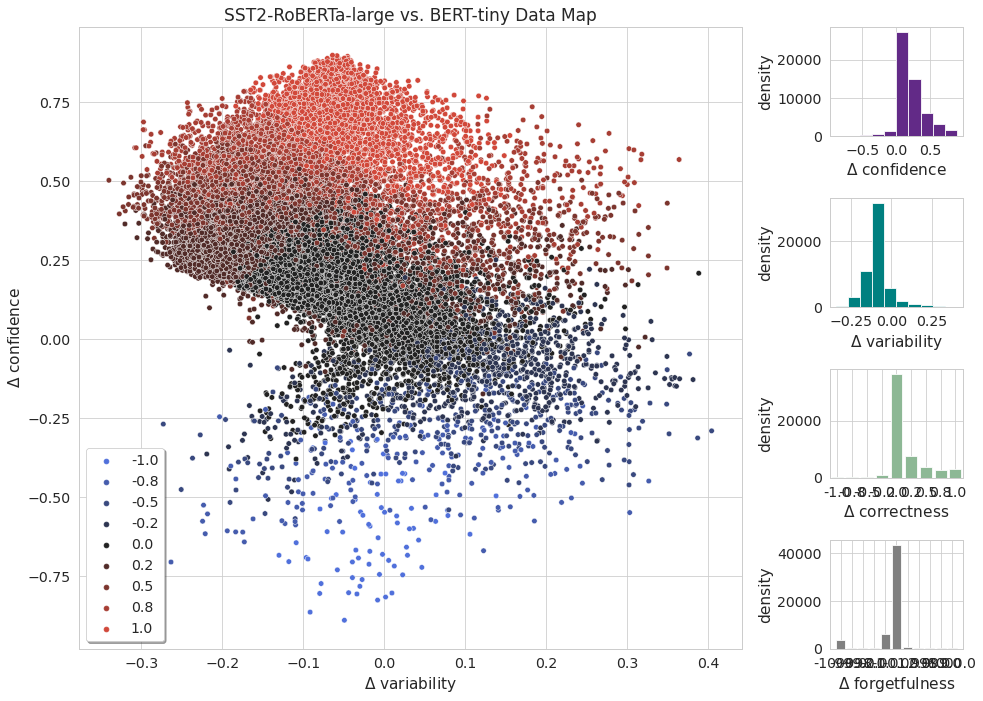

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# --------------------------------
dataframe = delta_td_df
plot_dir = ''
hue_metric = 'correct.'
title = 'SST2'
model = r'RoBERTa-large vs. BERT-tiny'
show_hist = True
max_instances_to_plot = 55000 #55000
# --------------------------------

# Set style.
sns.set(style='whitegrid', font_scale=1.6, context='paper') # font='Georgia'
print(f"Plotting figure for {title} using the {model} model ...")

# Subsample data to plot, so the plot is not too busy.
dataframe = dataframe.sample(n=max_instances_to_plot if dataframe.shape[0] > max_instances_to_plot else len(dataframe))

# Normalize correctness to a value between 0 and 1.
dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
dataframe['correct.'] = [float(f"{x:.1f}") for x in dataframe['corr_frac']]

main_metric = 'variability'
other_metric = 'confidence'

hue = hue_metric
num_hues = len(dataframe[hue].unique().tolist())
style = hue_metric if num_hues < 8 else None

if not show_hist:
    fig, ax0 = plt.subplots(1, 1, figsize=(8, 6))
else:
    fig = plt.figure(figsize=(14, 10), )
    gs = fig.add_gridspec(4, 2, width_ratios=[5, 1])  # 构造一个三行两列的图，两列的宽度比例是 5:1
    ax0 = fig.add_subplot(gs[:, 0]) # ax0是一个子图，位置在整个fig的第一列区域

# Make the scatterplot.
# Choose a palette.
pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

plot = sns.scatterplot(x=main_metric, y=other_metric,
                       ax=ax0, data=dataframe, hue=hue,
                       palette=pal, s=30) # style=style 添加style的话，就会使用不用的 marker，但是就没法保证 legend 按照值的大小排列了

# Annotate Regions.
# bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
# func_annotate = lambda text, xyc, bbc : ax0.annotate(text, xy=xyc, xycoords="axes fraction", fontsize=15, 
#                                                      color='black', va="center", ha="center", 
#                                                      rotation=350, bbox=bb(bbc))
# an1 = func_annotate("ambiguous", xyc=(0.9, 0.5), bbc='black')
# an2 = func_annotate("easy-to-learn", xyc=(0.27, 0.85), bbc='r')
# an3 = func_annotate("hard-to-learn", xyc=(0.35, 0.25), bbc='b')


if not show_hist:
    plot.legend(ncol=1, bbox_to_anchor=[0.175, 0.5], loc='right')
else:
    plot.legend(fancybox=True, shadow=True, ncol=1)

plot.set_xlabel(r'$\Delta$ variability')
plot.set_ylabel(r'$\Delta$ confidence')

if show_hist:
    plot.set_title(f"{title}-{model} Data Map", fontsize=17)

    # Make the histograms.
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 1])
    ax3 = fig.add_subplot(gs[2, 1])
    ax4 = fig.add_subplot(gs[3, 1])

    plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
    plott0[0].set_title('')
    plott0[0].set_xlabel(r'$\Delta$ confidence')
    plott0[0].set_ylabel('density')

    plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
    plott1[0].set_title('')
    plott1[0].set_xlabel(r'$\Delta$ variability')
    plott1[0].set_ylabel('density')

    plot2 = sns.countplot(x="correct.", data=dataframe, ax=ax3, color='#86bf91')
    ax3.xaxis.grid(True) # Show the vertical gridlines
    plot2.set_title('')
    plot2.set_xlabel(r'$\Delta$ correctness')
    plot2.set_ylabel('density')

    plot3 = sns.countplot(x="forgetfulness", data=dataframe, ax=ax4, color='gray')
    ax4.xaxis.grid(True) # Show the vertical gridlines
    plot3.set_title('')
    plot3.set_xlabel(r'$\Delta$ forgetfulness')
    plot3.set_ylabel('density')
fig.tight_layout()

plt.plot()
# # save
# filename = f'{plot_dir}/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
# fig.savefig(filename, dpi=300)
# print(f"Plot saved to {filename}")

2022-07-07 13:15:51,939 - WARNING - matplotlib.legend - No handles with labels found to put in legend.


Plotting figure for SST2 using the RoBERTa-large (Strong) vs. BERT-tiny (Weak) model ...


[]

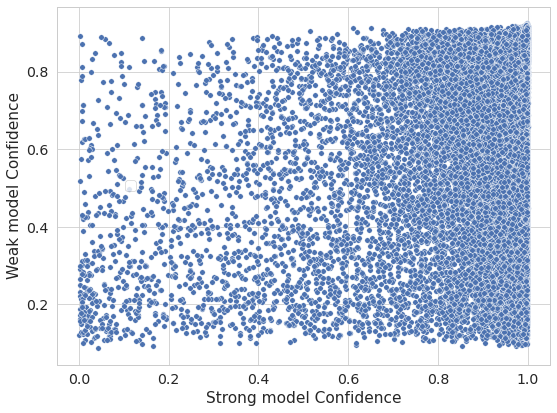

In [13]:

# --------------------------------
dataframe = con_compare_df
plot_dir = ''
title = 'SST2'
model = 'RoBERTa-large (Strong) vs. BERT-tiny (Weak)'
max_instances_to_plot = 55000 #55000
# --------------------------------

# Set style.
sns.set(style='whitegrid', font_scale=1.6, context='paper') # font='Georgia'
print(f"Plotting figure for {title} using the {model} model ...")

# Subsample data to plot, so the plot is not too busy.
dataframe = dataframe.sample(n=max_instances_to_plot if dataframe.shape[0] > max_instances_to_plot else len(dataframe))

main_metric = 'strong_model'
other_metric = 'weak_model'

fig, ax0 = plt.subplots(1, 1, figsize=(8, 6))

# Make the scatterplot.
# Choose a palette.
pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

plot = sns.scatterplot(x=main_metric, y=other_metric,
                       ax=ax0, data=dataframe,
                       palette=pal, s=30) 

plot.legend(ncol=1, bbox_to_anchor=[0.175, 0.5], loc='right')


plot.set_xlabel('Strong model Confidence')
plot.set_ylabel('Weak model Confidence')
fig.tight_layout()

plt.plot()

2022-07-07 13:16:38,293 - WARNING - matplotlib.legend - No handles with labels found to put in legend.


Plotting figure for SST2 using the RoBERTa-large (Strong) vs. BERT-tiny (Weak) model ...


[]

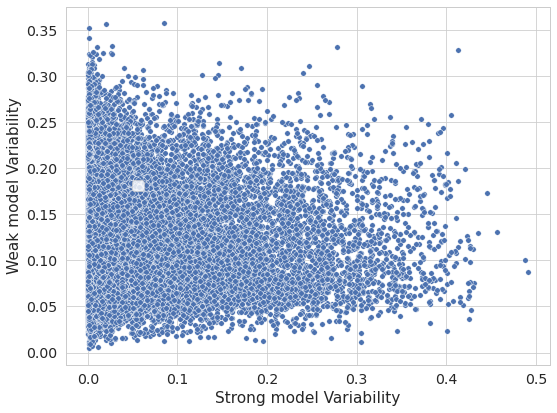

In [15]:

# --------------------------------
dataframe = var_compare_df
plot_dir = ''
title = 'SST2'
model = 'RoBERTa-large (Strong) vs. BERT-tiny (Weak)'
max_instances_to_plot = 55000 #55000
# --------------------------------

# Set style.
sns.set(style='whitegrid', font_scale=1.6, context='paper') # font='Georgia'
print(f"Plotting figure for {title} using the {model} model ...")

# Subsample data to plot, so the plot is not too busy.
dataframe = dataframe.sample(n=max_instances_to_plot if dataframe.shape[0] > max_instances_to_plot else len(dataframe))

main_metric = 'strong_model'
other_metric = 'weak_model'

fig, ax0 = plt.subplots(1, 1, figsize=(8, 6))

# Make the scatterplot.
# Choose a palette.
pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

plot = sns.scatterplot(x=main_metric, y=other_metric,
                       ax=ax0, data=dataframe,
                       palette=pal, s=30) 

plot.legend(ncol=1, bbox_to_anchor=[0.175, 0.5], loc='right')


plot.set_xlabel('Strong model Variability')
plot.set_ylabel('Weak model Variability')
fig.tight_layout()

plt.plot()